In [1]:
from pathlib import Path
from multiprocessing import Pool
import geopandas as gpd
from sentinel_helpers import scihub_band_paths

In [2]:
base_path = Path('input/tempelhofer_feld/')
input_files = list(base_path.glob('*.zip'))
area_of_interest = gpd.read_file(base_path / 'tempelhofer_feld.geojson')
ndvi_path = Path('output') / 'ndvi'

In [3]:
import rasterio as r
import rasterio.mask
import rasterio.plot as rplt
import numpy as np
from sentinel_helpers import scihub_normalize_range, scihub_cloud_mask
from zipfile import BadZipFile

In [4]:
# uncomment this cell to remove previous calculations
# ! rm -rf {ndvi_path / '*.tif'}

In [5]:
def calculate_ndvi(product_path):
    global area_of_interest
    
    try:
        b04_path, b08_path = scihub_band_paths(product_path, ['B04', 'B08'], '10m')
        cloud_mask = scihub_cloud_mask(product_path)
    except BadZipFile:
        # This is due to a problem of Scihub
        print(f'{product_path}: Problem reading product, skipping it')
        return

    with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
        # we want to only write the bare minimum data necessary to disk
        out_meta = b04.meta.copy()

        # we reproject the geojson file we fetched above and convert it so that rasterio
        # can use it as a mask; we subtract the cloud mask to avoid irregularities
        reprojected = area_of_interest.to_crs(out_meta['crs']).iloc[0].geometry
        mask = reprojected.difference(cloud_mask)
        
        if mask.area / reprojected.area < 0.25:
            print(f'{product_path}: Area is covered by clouds, skipping it')
            return
        
        miny, minx, maxy, maxx = mask.bounds
        
        # update the dimensions and save as geotiff, not jp2
        out_meta.update({
            'width': maxx - minx,
            'height': maxy - miny,
            'driver': 'GTiff',
            'dtype': 'float32'
        })    
        
        out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')

        ndvi_path.mkdir(exist_ok=True, parents=True)
        with r.open(ndvi_path / out_name, 'w+', **out_meta) as dst:
            # we take only the part out of our source raster that we actually need
            # crop=True clips off the borders
            b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], crop=True, nodata=-999)
            b08, _ = rasterio.mask.mask(b08, shapes=[mask], crop=True, nodata=-999) # we ignore the returned transform because it's identical to the previous one

            b04 = scihub_normalize_range(b04).astype('f4') # <- f4 = float32
            b08 = scihub_normalize_range(b08).astype('f4')

            # uncomment the following line to see if your masked shape looks correct
            #rplt.show(b04, transform=transform_b04)
            #rplt.show(b08, transform=transform_b04)

            # we want to be able to ignore divide by zero errors so the formula is nicer to write
            np.seterr(divide='ignore', invalid='ignore')
            ndvi = (b08 - b04) / (b08 + b04)

            # uncomment the following line to see if we calculated the index correctly
            # rplt.show(ndvi, transform=transform_b04)

            dst.write(ndvi)

In [6]:
from tqdm.notebook import tqdm

In [7]:
%%time

# we parallelize the NDVI calculation using a Python threadpool
with Pool() as pool:
    for _ in tqdm(pool.imap_unordered(calculate_ndvi, input_files), total=len(input_files)):
        # this loop is only here so we can get the progress bar
        pass

input/tempelhofer_feld/S2B_MSIL2A_20190330T101029_N0211_R022_T33UUU_20190330T144328.zip: Area is covered by clouds, skipping it
input/tempelhofer_feld/S2A_MSIL2A_20190626T102031_N0212_R065_T33UUU_20190626T125319.zip: Area is covered by clouds, skipping it
input/tempelhofer_feld/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUU_20190603T114652.zip: Problem reading product, skipping it
input/tempelhofer_feld/S2A_MSIL2A_20190404T101031_N0211_R022_T32UQD_20190404T174806.zip: Problem reading product, skipping it
input/tempelhofer_feld/S2A_MSIL2A_20190216T102111_N0211_R065_T33UUU_20190216T130428.zip: Problem reading product, skipping it
input/tempelhofer_feld/S2B_MSIL2A_20190419T101029_N0211_R022_T33UUU_20190419T132322.zip: Problem reading product, skipping it
input/tempelhofer_feld/S2A_MSIL2A_20190407T102021_N0211_R065_T33UUU_20190407T134109.zip: Problem reading product, skipping it
input/tempelhofer_feld/S2B_MSIL2A_20190512T102029_N0212_R065_T33UUU_20190512T134103.zip: Problem reading product, 

How many files could we process?

In [8]:
! ls -l {ndvi_path} | wc -l

28


## Plot the NDVI

See [02c Multithreading.ipynb](./02c Multithreading.ipynb) for a performance comparison of single vs multi-threaded iteration to average the ndvi.

In [18]:
from numpy import ma

In [9]:
output_files = list(ndvi_path.glob('*.tif'))

In [40]:
def average(file_path):
    with r.open(file_path) as src:
        # masked=True makes sure to respect the nodata value and reads the data
        # as a numpy MaskedArray, which lets us use `numpy.ma`'s methods
        data = src.read(1, masked=True)
        return file_path, ma.average(data)

In [43]:
%%time
with Pool() as pool:
    averages = [avg for avg in tqdm(pool.map(average, output_files), total=len(output_files))]


CPU times: user 48.5 ms, sys: 165 ms, total: 213 ms
Wall time: 754 ms


In [52]:
import pandas as pd

In [53]:
paths, vals = zip(*averages)
dates = map(lambda p: p.name.split('_')[1], paths)
df = pd.DataFrame(
    vals, index=pd.DatetimeIndex(dates)
)

<AxesSubplot:>

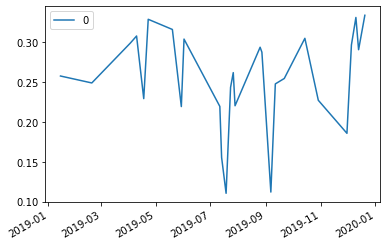

In [54]:
df.plot()